In [8]:
# Chris Lu
# March 30 2025
# Package Setup
# Model an OLS Line of the Modern Sakura Blooming Days to Temperatures

# Package setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import numpy as np

# Configure seaborn
sns.set(style="whitegrid", context="talk")

# Load dataset
df = pd.read_csv("modern_bloom.csv")

# Rename columns for clarity
df.columns = ['year', 'flower_date', 'flower_doy', 'march_temp_c']

In [9]:
## OLS Modelling With nonrobust SE.
# Define X and y
X = sm.add_constant(df['march_temp_c'])  # Add intercept
y = df['flower_doy']

# Fit the model
model = sm.OLS(y, X).fit()

# Output summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             flower_doy   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     30.81
Date:                Sun, 30 Mar 2025   Prob (F-statistic):           5.65e-07
Time:                        23:54:04   Log-Likelihood:                -195.46
No. Observations:                  67   AIC:                             394.9
Df Residuals:                      65   BIC:                             399.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           86.1149      0.762    112.978   

In [10]:
## Modelling with Robust HC1 SE
# Define X and y
X = sm.add_constant(df['march_temp_c'])  # Add intercept
y = df['flower_doy']

# Fit the model with robust standard errors
model2 = sm.OLS(y, X).fit(cov_type='HC1')

# Output the summary
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:             flower_doy   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     21.08
Date:                Sun, 30 Mar 2025   Prob (F-statistic):           2.07e-05
Time:                        23:54:05   Log-Likelihood:                -195.46
No. Observations:                  67   AIC:                             394.9
Df Residuals:                      65   BIC:                             399.3
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           86.1149      0.901     95.591   

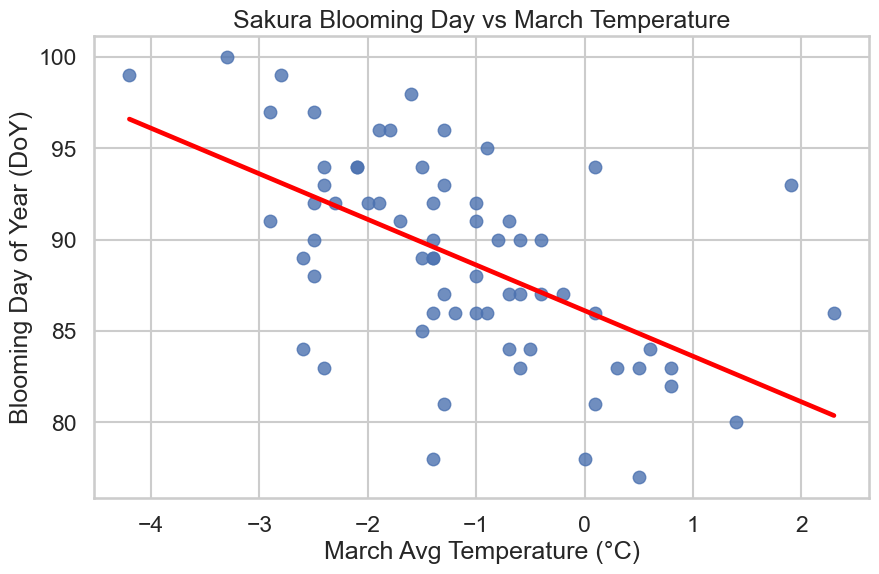

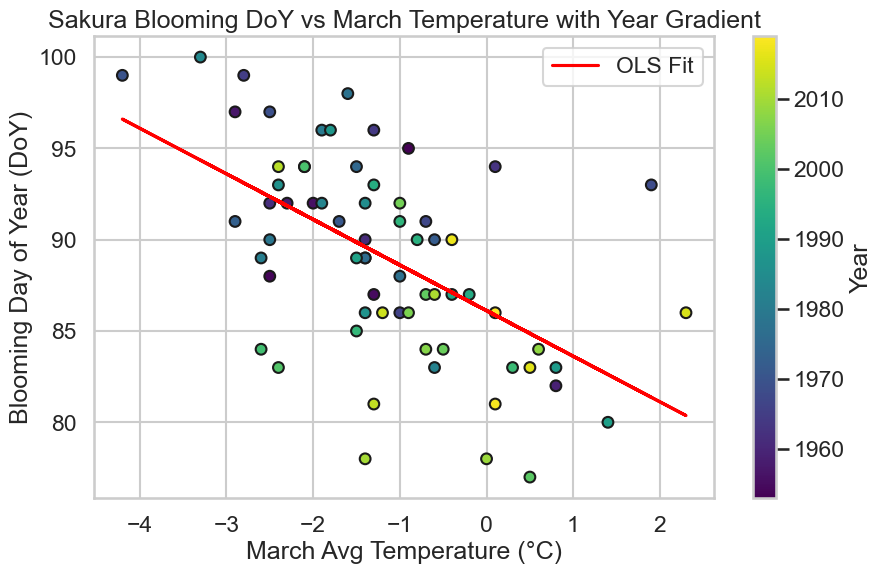

In [11]:
## Visualizations
# Scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='march_temp_c', y='flower_doy', data=df, ci=None, line_kws={'color': 'red'})
plt.title("Sakura Blooming Day vs March Temperature")
plt.xlabel("March Avg Temperature (°C)")
plt.ylabel("Blooming Day of Year (DoY)")
plt.show()

# Scatterplot with year-based color gradient
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['march_temp_c'], df['flower_doy'], c=df['year'], cmap='viridis', s=60, edgecolor='k')
plt.plot(df['march_temp_c'], model.predict(X), color='red', label='OLS Fit')
plt.colorbar(scatter, label='Year')
plt.title("Sakura Blooming DoY vs March Temperature with Year Gradient")
plt.xlabel("March Avg Temperature (°C)")
plt.ylabel("Blooming Day of Year (DoY)")
plt.legend()
plt.show()

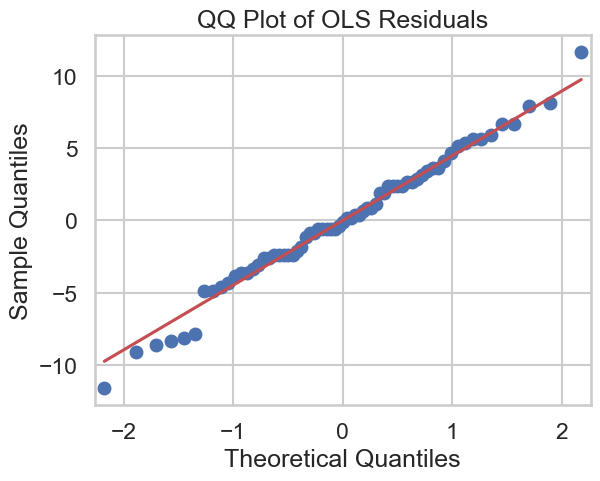

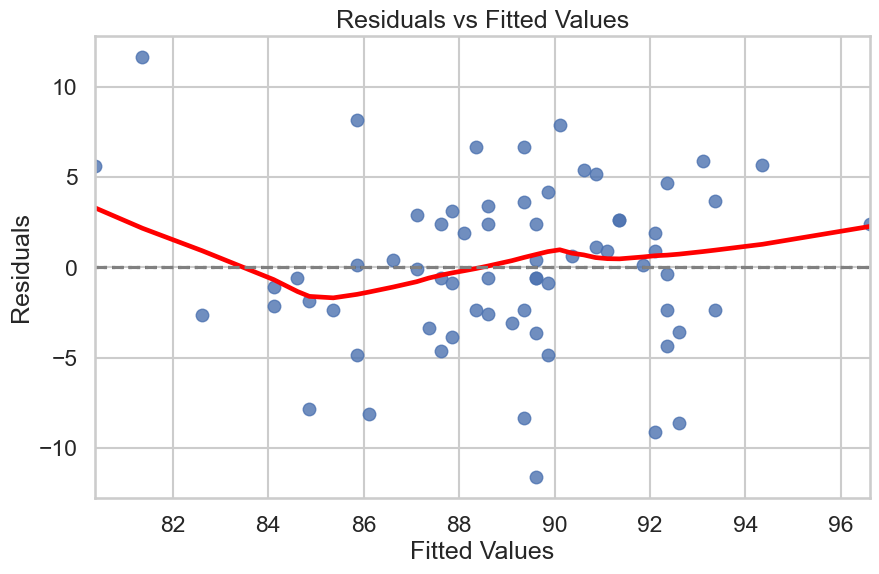

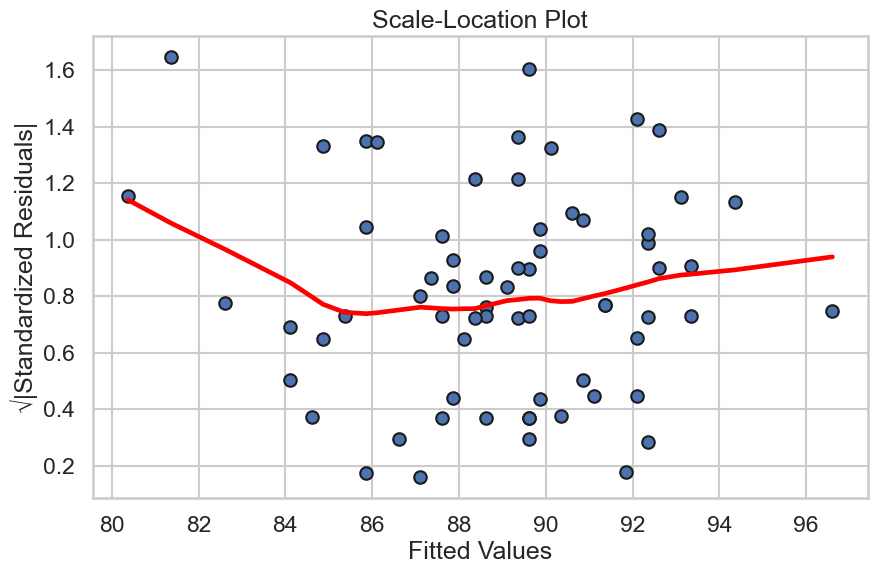

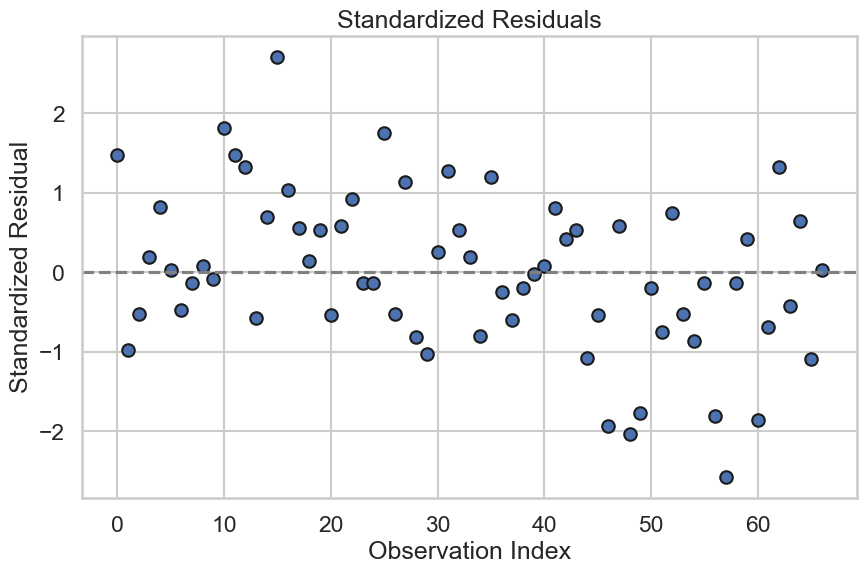

In [12]:
## Assumptions and Violations Verification Visualizations
# QQ plot of residuals
residuals = model.resid
fig = qqplot(residuals, line='s')
plt.title("QQ Plot of OLS Residuals")
plt.show()

# Residuals vs Fitted
fitted_vals = model.predict(X)
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

#Compute the Standardized Residuals
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal
fitted_vals = model.predict(X)

# Scale-Location Plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, np.sqrt(np.abs(standardized_residuals)), edgecolor='k')
sns.regplot(x=fitted_vals, 
            y=np.sqrt(np.abs(standardized_residuals)), 
            scatter=False, ci=False, lowess=True, line_kws={'color': 'red'})
plt.title("Scale-Location Plot")
plt.xlabel("Fitted Values")
plt.ylabel("√|Standardized Residuals|")
plt.show()

# Standardized Residuals Plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(standardized_residuals)), standardized_residuals, edgecolor='k')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title("Standardized Residuals")
plt.xlabel("Observation Index")
plt.ylabel("Standardized Residual")
plt.show()